<a id="Title"></a>
# <span style="color:teal;font-weight:bold;">Spaceship Titanic 🩹 Data imputation</span>

This notebook is the third part of my <span style="font-weight:bold;color:green">Spaceship Titanic series</span>, focused on data correction and imputation techniques, which have significantly improved my model's performance.

📘 Series Overview

1. <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-getting-familiar">Spaceship Titanic 🏁 Getting familiar</a>.
My first approach using the raw dataset, resulting in a submission score of **0.79635**, placing me in the **top 40% scores**.
2. <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a> By feature engineering (still without fixing missing data), my score improved up to **0.80336**, climbing into the **top 16% scores**.
3. <span style="font-weight:bold">Spaceship Titanic 🩹 Data imputation.</span> (You're here!)

<div style="color:white;
    display:fill;
    border-radius:15px;
    margin-left: 70px;
    margin-right: 70px;
    background-color:lightblue;
    font-size:115%;
    font-family:Verdana;
    letter-spacing:0.5px">

<p style="padding: 20px;color:black;text-align:center;">
In <span style="color:green;font-weight:bold;">this episode</span>, I focus on <span style="font-weight:bold;">data correction techniques, including Machine Learning imputation</span>, getting a <span style="color:green;font-weight:bold;">submission score of 0.80757</span>, among the <span style="color:green;font-weight:bold;">top 5% scores in the LB ranking</span>!

</p>
</div>

📊 Visual Summary of the Journey

To help you visualize the progression, here's a snapshot of my leaderboard scores as of 2025-04-16, with 2186 competitors:

🟥 First version: Raw data, decent start (~60th percentile).

🟫 Second version: Feature engineering kicks in (~top 16%).

🟩 Current version: Data imputation pushes the score to 0.80757, entering the top 5%!

![Summary_episodes](https://github.com/Fertmeneses/titanic-spaceship-kaggle/blob/main/assets/Summary_LB.png?raw=true)

Throughout this notebook, I’ll walk you through the steps and ideas behind my data correction process, explain my choices, and show how it improved model performance.

Let’s dive in 👇

<hr>

# <font color='teal'>Outline</font> <a class="anchor"  id="Outline"></a>

[**Load data and preprocess**](#Load-data-and-preprocess)

  - [Load original data](#Load-original_data)

  - [Basic feature engineering](#Basic-feature-engineering)

[**Machine learning data imputation**](#ML-data-imputation)

  - [Hyperparameters optimization](#Hyperparameters-optimization)

  - [Data imputation in action](#Data-imputation-in-action)

  - [MLI submission performance](#MLI-Submission-performance)

[**Manual data correction**](#Manual-data-correction)

  - [Expense-related features](#Expense-related-features)

  - [Cryosleep feature](#Cryosleep-feature)

  - [HomePlanet feature](#HomePlanet-feature)

  - [VIP feature](#VIP-feature)

  - [Cabin_isPort feature](#Cabin-isPort-feature)

  - [Checkpoint: MC completed](#Checkpoint-MC-completed)

  - [FE+MC+SC submission performance](#FE-MC-SC-submission-performance)

[**Manual correction + ML Imputation**](#MC-plus-MLI)

  - [Optimization and imputation](#Optimization-and-imputation)

  - [FE+MC+MLI submission performance](#FE-MC-MLI-submission-performance)
 
[**Conclusions**](#Conclusions)

<a id="Load-data-and-preprocess"></a>
# <span style="color:teal;font-weight:bold;">Load data and preprocess</span>

In this section, I start by loading the original dataset and performing **basic feature engineering**. 

At this stage, I focus only on **simple transformations** such as renaming columns and extracting information from individual features. More advanced techniques that involve interactions between multiple features will be introduced in later steps.

In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-04-26 14:34:40.002789


<a id="Load-original-data"></a>
## <span style="color:teal;font-weight:bold;">Load original data</span>

In the following steps, I load the original training and test datasets and extract some **key information** to get a sense of the data:

- Display 10 random rows from the training set as a quick preview.

- Show the number of rows in both the training and test sets.

- List the feature names along with their data types.

- Calculate the number of missing values per feature and per row in each dataset.

In [2]:
import pandas as pd
import numpy as np
from termcolor import colored

# Set the reference benchmark for submission score, from previous episode:
benchmark_1 = 0.80336

# Load original datasets:
train_df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv') # Training dataset
test_df = pd.read_csv('kaggle/input/spaceship-titanic/test.csv') # Testing dataset
# Keep the passengerID features separately:
train_ID = train_df['PassengerId']
test_ID = test_df['PassengerId']
# Display a 10 random examples:
np.random.seed(1) # Ensure reproducitibility
samples = np.random.choice(range(len(train_df)), 10, replace=False)
display(train_df.iloc[samples]) # Examples
# Print global information:
print('\nNumber of rows in train/test datasets:\n')
print(len(train_df),'/',len(test_df))
print('\nFeatures: names and data types:\n')
print(train_df.dtypes)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1454,1539_01,Europa,NaN,A/17/S,55 Cancri e,32.0,False,54.0,3782.0,0.0,21.0,5.0,Alyadum Barmant,True
218,0232_01,Earth,True,G/36/S,PSO J318.5-22,27.0,False,0.0,NaN,0.0,0.0,0.0,Nica Bakerrison,False
7866,8392_01,Earth,False,F/1610/S,PSO J318.5-22,24.0,False,86.0,669.0,1.0,0.0,0.0,Therly Brightez,False
7622,8141_01,Earth,True,G/1310/S,TRAPPIST-1e,38.0,False,0.0,0.0,0.0,0.0,0.0,Stenny Belley,True
4108,4387_01,Mars,False,F/902/P,PSO J318.5-22,32.0,False,192.0,0.0,441.0,18.0,0.0,Apix Wala,False
4363,4645_01,Europa,False,B/184/S,TRAPPIST-1e,48.0,False,0.0,9633.0,0.0,1.0,2.0,Aton Bacistion,True
343,0379_01,Earth,False,G/63/P,TRAPPIST-1e,31.0,False,198.0,0.0,591.0,0.0,164.0,Brita Moodson,True
5966,6324_01,Earth,False,E/420/S,NaN,31.0,False,19.0,509.0,0.0,0.0,177.0,Lesley Hinetthews,False
669,0699_01,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,True
6506,6865_01,Europa,False,D/208/S,TRAPPIST-1e,27.0,NaN,69.0,2878.0,0.0,4232.0,3798.0,Thabih Peducting,False



Number of rows in train/test datasets:

8693 / 4277

Features: names and data types:

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [3]:
def compute_missing_values(train_df,test_df):
    """
    Analyzes the missing values in each feature listed in the testing
    dataset, for both training and testing datasets.
    --- Inputs ---
    {train_df, test_df} [Dataframes]: Training and testing datasets.
    """
    print('\nMissing values in train/test datasets:\n')
    for col in test_df.columns:
        # Count missing values and obtain percentages:
        N_train = train_df[col].isna().sum() 
        N_test = test_df[col].isna().sum()
        p_train = N_train/len(train_df)*100 # [%]
        p_test = N_test/len(test_df)*100 # [%]
        # Print results:
        color_train = 'red' if N_train else 'green'
        color_test = 'red' if N_test else 'green'
        rmargin = 60-len(col)
        text_train = colored(f'{N_train} ({p_train:.1f}%)', color_train)
        text_test = colored(f'{N_test} ({p_test:.1f}%)', color_test)
        print(f'{col}:',f'{text_train} / {text_test}'.rjust(rmargin))
    # Count missing values in each row:
    N_nan_train = train_df.apply(lambda x: x.isna().sum(), axis=1)
    N_nan_test = test_df.apply(lambda x: x.isna().sum(), axis=1) 
    # Print number of rows with N missing values:
    print('')
    for n in set(N_nan_train).union(set(N_nan_test)):
        print(f'Number of rows with {n} missing values: {sum(N_nan_train==n)}/{sum(N_nan_test==n)}')

In [4]:
compute_missing_values(train_df,test_df)


Missing values in train/test datasets:

PassengerId:             0 (0.0%) / 0 (0.0%)
HomePlanet:           201 (2.3%) / 87 (2.0%)
CryoSleep:            217 (2.5%) / 93 (2.2%)
Cabin:               199 (2.3%) / 100 (2.3%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  203 (2.3%) / 93 (2.2%)
RoomService:          181 (2.1%) / 82 (1.9%)
FoodCourt:           183 (2.1%) / 106 (2.5%)
ShoppingMall:         208 (2.4%) / 98 (2.3%)
Spa:                 183 (2.1%) / 101 (2.4%)
VRDeck:               188 (2.2%) / 80 (1.9%)
Name:                 200 (2.3%) / 94 (2.2%)

Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1867/879
Number of rows with 2 missing values: 203/113
Number of rows with 3 missing values: 17/4


For more comments about the nature and interpretation of each feature, please visit <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>

<a id="Basic-feature-engineering"></a>
## <span style="color:teal;font-weight:bold;">Basic feature engineering</span>

Except for the *PassengerID* feature, most features in both the training and test sets have around **2% missing values**. In order to correct them, I'll make some reasonable assumptions and deductions using the original information. 

In this **basic feature engineering** step, I avoid creating new features that combine multiple columns, since doing so could multiply the missing values. Instead, I focus on:

- Extracting additional information from **individual features**.

- Making simple transformations, such as **renaming** columns.

For more details about the reasoning behind each transformation, feel free to check out my earlier notebook:

<a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>

In the following cells, I just apply that code to prepare the data.

In [5]:
# First generate the corrected datasets:
train_df_FE = train_df.copy()
test_df_FE = test_df.copy()

# # # "PassengerId": new features "IDgroup" and "GroupMembers" # # #

train_df_FE['IDgroup'] = train_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
test_df_FE['IDgroup'] = test_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
# Identify ocurrences for every unique value in IDgroup:
ocurrences = pd.concat([train_df_FE['IDgroup'], test_df_FE['IDgroup']]).value_counts().to_dict()
for dataset in [train_df_FE,test_df_FE]:
    dataset['GroupMembers'] = dataset['IDgroup'].apply(lambda x: ocurrences[x])
# Drop unnecessary feature:
train_df_FE = train_df_FE.drop('PassengerId',axis=1)
test_df_FE = test_df_FE.drop('PassengerId',axis=1)

# # # "CryoSleep": make numeric # # #

for dataset in [train_df_FE,test_df_FE]:
    dataset['CryoSleep'] = dataset['CryoSleep'].apply(
        lambda x: np.nan if x!=x else (1 if x else 0))

# # # "VIP": make numeric # # #

for dataset in [train_df_FE,test_df_FE]:
    dataset['VIP'] = dataset['VIP'].apply(
        lambda x: np.nan if x!=x else (1 if x else 0))

# # # "Cabin": new features "Cabin_Deck", "Cabin_num" and "Cabin_isPort" # # #

# Generate list of unique values:
cabin = list(train_df['Cabin'].loc[~train_df['Cabin'].isna()].values)+\
        list(test_df['Cabin'].loc[~test_df['Cabin'].isna()].values)
# Separate "Cabin" into three parts:
cabin_X = ['Cabin_Deck','Cabin_num','Cabin_Side']
for i,cabin in enumerate(cabin_X):
    train_df_FE[cabin] = train_df['Cabin'].apply(
        lambda x: np.nan if x!=x else (
            x.split('/')[i]))
    test_df_FE[cabin] = test_df['Cabin'].apply(
        lambda x: np.nan if x!=x else (
            x.split('/')[i]))
# Make 'Cabin_num' numeric:
for dataset in [train_df_FE,test_df_FE]:
    dataset['Cabin_num'] = pd.to_numeric(dataset['Cabin_num'], errors='coerce')

# Change 'Cabin_Side' to 'Cabin_isPort' and make it boolean/numeric:
train_df_FE['Cabin_isPort'] = train_df_FE['Cabin_Side'].apply(
    lambda x: np.nan if x!=x else (1 if x=='P' else 0))
test_df_FE['Cabin_isPort'] = test_df_FE['Cabin_Side'].apply(
    lambda x: np.nan if x!=x else (1 if x=='P' else 0))
# Drop unnecesary features:
for feature in ['Cabin','Cabin_Side']:
    train_df_FE = train_df_FE.drop(feature,axis=1)
    test_df_FE = test_df_FE.drop(feature,axis=1)

# # # "Destination" redefinition # # #

train_df_FE["Destination"] = train_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)
test_df_FE["Destination"] = test_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)

# # # Expense-features redefinition # # #

for dataset in [train_df_FE, test_df_FE]:
    dataset.rename(columns={
        'RoomService': 'ExpRS',
        'FoodCourt': 'ExpFC',
        'ShoppingMall': 'ExpSM',
        'Spa': 'ExpSpa',
        'VRDeck': 'ExpVR'
        }, inplace=True)

# # # "Name" feature: new features "Name_Last" and "Ocurrence_LastName" # # #

# Training dataset:
train_df_FE['Name_Last'] = train_df['Name'].apply(
    lambda x: np.nan if x!=x else (
        x.split(' ')[-1]))
# Testing dataset:
test_df_FE['Name_Last'] = test_df['Name'].apply(
    lambda x: np.nan if x!=x else (
        x.split(' ')[-1]))
# Identify ocurrences for every unique value in Name_Last:
ocurrences = pd.concat([train_df_FE['Name_Last'], test_df_FE['Name_Last']]).value_counts().to_dict()
for dataset in [train_df_FE,test_df_FE]:
    dataset['Ocurrence_LastName'] = dataset['Name_Last'].apply(
        lambda x: np.nan if x!=x else ocurrences[x])
# Drop unnecessary features:
train_df_FE = train_df_FE.drop('Name',axis=1)
test_df_FE = test_df_FE.drop('Name',axis=1)

🧾 **Summary of Features After Basic Engineering**

Below is a summary of all the features created or refined during the basic feature engineering step:

| Feature | Definition |
| :---: | :--- |
| *IDgroup* | Identifier for the group a passenger is traveling with. Group members are often (but not always) family. |
| *GroupMembers* | Number of passengers sharing the same *IDgroup* (including self). |
| *Name_Last* | Last name of the passenger. |
| *Ocurrence_LastName* | Number of passengers sharing the same last name (including self). |
| *HomePlanet* | The planet the passenger departed from, typically their planet of permanent residence. |
| *CryoSleep* | Indicates whether the passenger elected for cryogenic sleep during the voyage. Those in cryosleep are confined to their cabins. |
| *Destination* | The planet the passenger is expected to disembark. |
| *Age* | Passenger's age. |
| *VIP* | Indicates if the passenger paid for VIP service. |
| *Cabin_Deck* | The deck where the passenger’s cabin is located. |
| *Cabin_num* | Numeric identifier of the passenger's cabin. |
| *Cabin_isPort* | Indicates the side of the ship: 1 for Port, 0 for Starboard. |
| *ExpRS* | Expenditure at the Room Service luxury amenity. |
| *ExpFC* | Expenditure at the Food Court luxury amenity. |
| *ExpSM* | Expenditure at the Shopping Mall luxury amenity. |
| *ExpSpa* | Expenditure at the Spa luxury amenity. |
| *ExpVR* | Expenditure at the VR Deck luxury amenity. |

<a id="ML-data-imputation"></a>
# <span style="color:teal;font-weight:bold;">Machine learning data imputation</span>

Now it's time to correct the missing data... Normally, one might start by first **analyzing feature correlations** and applying **manual corrections** where possible, and then fill any remanining missing values based on standard defaults, such as mean values. 

However, in this notebook I take a different route and implement a **Machine Learning data imputation method**. Following the same spirit of this competition, which is to predict the *Transported* feature based on all other features, the idea is to **predict missing values of any feature** using the known values of the remaining features, excluding the *Transported* feature.

Machine Learning imputation (MLI) can be applied in two different stages:
- **Before** manual corrections (quicker and more automated).
- **After** manual corrections (likely more precise).

In this notebook, I **explore both approaches** and compare their impact on the final submission performance.

🧠 **My MLI Method: Step-by-Step**

The imputation strategy is applied feature-by-feature, and each target feature is treated independently. Here's how it works:

1. **Combine training and testing datasets** into a single dataset $W$, excluding the *Transported* feature.

2. **Select the relevant predictor features**.
> For example, I exclude the *Name_Last* feature as a predictor,since it has too many unique values and would probably confuse the ML model. Non-relevant features are dropped from $W$ at this stage.

3. **Select a subset $W_c$ that only includes complete rows**, without missing values in any feature.

4. **Split $W_c$ into training $W_{c,train}$ and testing $W_{c,test}$ sets** using a 75/25 ratio..

5. **Optimize and choose the ML hyperparameters**.
> The ML model is trained in the the $W_{c,train}$ dataset and evaluated in the $W_{c,test}$ dataset. This step defines the final ML model $M$ for the target feature.

6. **Retrain the $M$ model** on the full $W_c$ dataset.
> Evaluation metrics:
> - Classification tasks (non-numeric target feature): either [**accuracy**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [**F1-score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).
> - Regression tasks (numeric target feature), either [**Mean Absolute Error (MAE)**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) or [**Root Mean Squared Error (RMSE)**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html).

7. **Make a dataset $W_{target}$** with all rows from $W$ where the target feature is missing.

8. **Temporarily fill missing values in the predictors** in the $W_{target}$ dataset, using mean (for numerical) or mode (for non-numeric) values from the full $W$ dataset.
> This correction is only for model input, these temporary values won't be stored in the final data.

9. Use the trained model $M$ to **predict the mising values from the target feature** in $W_{target}$.

10. **Update the $W$ dataset** with the predicted values for the target feature.
> Other missing values (from the predictor features) remain untouched.

11. **Separate the imputed $W$ dataset** back into training and testing datasets.

<a id="Hyperparameters-optimization"></a>
## <span style="color:teal;font-weight:bold;">Hyperparameters optimization</span>

The following section defines the hyperparameter optimization function, which essentially performs a **manual grid search**.

I focus on **two model families**:

- Random Forest (Classifier & Regressor)
- Gradient Boosting (Classifier & Regressor)

The grid search explores variations of the following hyperparameters:

- n_estimators (number of trees)
- max_depth (maximum depth of each tree)

⚙️ Note: This is a simplified search strategy designed to balance performance and execution time.
Users are very welcome to extend or adapt this method to their own needs.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import (RandomForestClassifier,
RandomForestRegressor,
GradientBoostingClassifier,
GradientBoostingRegressor
)


def ML_data_imp_optim(dfs,target_feat,n_est_options=[50,100],
                      max_d_options=[3,5,7],
                      drop_feats=['Name_Last','IDgroup','Transported'],
                      reg_error='RMSE',cla_error='F1'):
    """
    Optimize Machine Learning model for imputing missing values for a target feature, 
    using the known values of the other features.
    --- Inputs ---
    {dfs} [List]: Each element is a pandas dataframe that will be considered for the
    univocal correlation and then corrected.
    {target_feat} [String]: Name of the target feature.
    {n_est_options} [List]: Options for number of estimators, common to all ML models.
    {mad_d_options} [List]: Options for maximum depth, common to all ML models.
    {drop_feats} [List]: Each element is a feature from the input datasets that
    will be dropped, then it will not participate in the data imputation process.
    {reg_error} ['RMSE' or 'MAE']: Type of error to evaluate regression results. 
    'RMSE' means Root Mean Squared Error, 'MAE' means Mean Absolute Error.
    {cla_error} ['F1' or 'Acc']: Type of error to evaluate classification results. 'F1'
    means F1-score (involves recall and precision), 'Acc' means Accuracy error. 
    Note: F1 only works on binary features, for multiclass feature the error will
    always be 'Acc'.
    """
    # Initiate variables, concatenate datasets and drop selected features:
    df_all = pd.concat(dfs) # Combine datasets
    df_all = df_all.drop(drop_feats,axis=1)
    # One-Hot Encode object features (other than the target feature):
    feats_enc = [feat for feat in df_all.columns if 
                 df_all[feat].dtype=='object' and feat!=target_feat]
    if len(feats_enc)>0:
        data_enc = pd.get_dummies(df_all[feats_enc])
        df_all = pd.concat([df_all, data_enc], axis=1)
        # Drop source-encoded features: 
        df_all = df_all.drop(feats_enc,axis=1)   

    # Prepare training and testing datasets to select ML model:  
    df_all_full = df_all[~df_all.isnull().any(axis=1)] # Identify complete rows    
    df_train, df_test = train_test_split(df_all_full, test_size=0.25) # Split train/test datasets
    x_train = df_train.drop([target_feat],axis=1)
    y_train = df_train[target_feat]
    x_test = df_test.drop(target_feat,axis=1)
    y_test = df_test[target_feat]

    # Identify if feature's type is 'object' or not:
    is_object = True if df_all[target_feat].dtype=='object' else False
    # If not object, then check if it is in fact boolean:
    is_boolean = True if len(set(df_all_full[target_feat]))==2 and not is_object else False
    is_numeric = True if (not is_object and not is_boolean) else False
    
    # Prepare ML models according to classification task:
    if is_object:
        models = {'Random Forest Classifier':RandomForestClassifier(),
                  'Gradient Boosting Classifier':GradientBoostingClassifier()}
    else:
        models = {'Random Forest Regressor':RandomForestRegressor(),
                  'Gradient Boosting Regressor':GradientBoostingRegressor()}
    # Train and test ML models and keep the best:
    n_est_best, max_d_best, best_model, best_score = 'None','None','None',0 # Initiate
    best_score = 0 if not is_numeric else 1e6
    for model in models:
        ML_model = models[model]
        for n_est in n_est_options:
            for max_d in max_d_options:
                # Prepare ML model:
                ML_model.random_state = 0 # Set random seed
                ML_model.n_estimators = n_est # Set number of estimators
                ML_model.max_depth = max_d # Set maximum depth
                # Train the model, predict target feature:
                ML_model.fit(x_train,y_train) # Train the model
                preds = ML_model.predict(x_test) # Predict target feature
                # If target feature is boolean, transform to 0/1:
                if is_boolean:
                    preds = (preds > .5).astype(float)
                # Assign score:
                if is_object or is_boolean: # Classification
                    if cla_error == 'F1' and len(set(y_test))<3:
                        score = f1_score(y_test,preds)
                        metrics = 'F1-score'
                    elif cla_error == 'Acc' or len(set(y_test))>2:
                        score = accuracy_score(y_test,preds)
                        metrics = 'Accuracy score'
                else: # Regression
                    if reg_error == 'RMSE':
                        score = root_mean_squared_error(y_test,preds)
                    elif reg_error == 'MAE':
                        score = mean_absolute_error(y_test,preds)
                # Update best model and benchmaks:
                if (score > best_score and not is_numeric) or (score < best_score and is_numeric):
                    best_score = score
                    best_model = model
                    n_est_best = n_est
                    max_d_best = max_d
    print('Best model for',colored(target_feat,attrs=['bold']),':')
    print(f'{best_model}, {n_est_best} estimators, max depth {max_d_best}')
    if is_object or is_boolean:
        print(f'{metrics} (classification): {best_score:.4f}.\n')
    else:
        print(f'{reg_error} (regression): {best_score:.2f} (mean value {np.mean(df_all_full[target_feat]):.2f}).\n')

Below, I show some options during my exploration for hyperparameters optimization. The **target features** are implicitely defined as all those features appearing in the search. 

📝 Note: Because hyperparameter optimization can be time-consuming, I’ve avoided running it during this notebook execution. If you’d like to experiment with the optimization process yourself, simply set: *optimize_hyps*=True.

In [7]:
# The following options for hyperparameters are examples from my last fine tuning:   
hyps_dict = {
    'HomePlanet': {'n_est_opts': [300,400,500], 'max_d_opts': [3,4,5]},
    'CryoSleep': {'n_est_opts': [100,125,150], 'max_d_opts': [3,4,5]},
    'Destination': {'n_est_opts': [75,100,125], 'max_d_opts': [2,3,4]},
    'Age': {'n_est_opts': [10,30,50], 'max_d_opts': [3,4,5]},
    'VIP': {'n_est_opts': [75,100,125], 'max_d_opts': [5,6,7]},
    'ExpRS': {'n_est_opts': [800,1200,1500], 'max_d_opts': [1,2,3]},
    'ExpFC': {'n_est_opts': [800,1200,1500], 'max_d_opts': [1,2,3,4]},
    'ExpSM': {'n_est_opts': [800,1000,1200], 'max_d_opts': [3,4,5]},
    'ExpSpa': {'n_est_opts': [800,1200,1500], 'max_d_opts': [1,2,3,4]},
    'ExpVR': {'n_est_opts': [1000,1200,1400], 'max_d_opts': [3,4,5]},
    'Cabin_Deck': {'n_est_opts': [300,500,700], 'max_d_opts': [4,5,6]},
    'Cabin_num': {'n_est_opts': [75,100,125], 'max_d_opts': [2,3,4]},
    'Cabin_isPort': {'n_est_opts': [300,500,700], 'max_d_opts': [4,5,6]},
}

# Choose optimize_hyps=True if you want to run the ML optimization process:
optimize_hyps = False
if optimize_hyps:
    # Impute missing values using ML:
    for feat in hyps_dict:
        # Correct missing values on single feature for both training and testing datasets:
        n_est_options = hyps_dict[feat]['n_est_opts']
        max_d_options = hyps_dict[feat]['max_d_opts']
        ML_data_imp_optim([train_df_FE,test_df_FE],feat,
                          n_est_options=n_est_options,max_d_options=max_d_options,
                          reg_error='RMSE',cla_error='F1')

The results of my search are summarized in the next table, in which:

- GBC stands for Gradient Boosting Classifier.
- GBR stands for Gradient Boosting Regressor.
- RFC stands for Random Forest Classifier.
- RFR stands for Random Forest Regressor.

To help interpret the regression results, the mean value of each feature in the training set is also included as a reference point.

<!-- Scoring: F1/Accuracy (classification), RMSE (regression) -->
| Feature | ML model | n_estimators | max_depth | F1-score | RMSE score | Mean value (Reg.) |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **HomePlanet** | GBC | 500 | 5 | **0.9521** | - | - |
| **CryoSleep** | GBR | 100 | 3 | **0.9351** | - | - |
| **Destination** | RFC | 75 | 2 | **0.7011** | - | - |
| **Age** | GBR | 30 | 5 | - | **12.75** | 28.81 |
| **VIP** | GBR | 75 | 7 | **0.1795** | - | - |
| **ExpRS** | GBR | 1200 | 2 | - | **538.00** | 221.44 |
| **ExpFC** | RFR | 1200 | 3 | - | **1297.17** | 459.85 |
| **ExpSM** | RFR | 1000 | 4 | - | **502.27** | 177.15 |
| **ExpSpa** | RFR | 1200 | 3 | - | **1131.54** | 308.05 |
| **ExpVR** | RFR | 1200 | 4 | - | **914.60** | 302.65 |
| **Cabin_Deck** | GBC | 300 | 6 | **0.6823** | - | - |
| **Cabin_num** | GBR | 75 | 4 | - | **393.70** | 604.99 |
| **Cabin_isPort** | GBR | 300 | 6 | **0.5239** | - | - |

📊 **ML Imputation Performance Summary**

Overall, the ML models **perform remarkably well** across most features, although it has limitations as well. Here’s a breakdown by feature:

- For example, imputing the ***Destination*** feature by random chance would yield ~33% accuracy, but the ML model achieves **~70% accuracy**.

- For the ***HomePlanet*** and ***CryoSleep*** features, the predictions are very reliable, reaching **F1-scores above 90%**.

- For the ***Age*** feature, the RMSE score is relatively low compared to their mean values, indicating **reliable predictions**.

- Conversely, for the **expense fields** the RMSE score is relatively high compared to their mean values, suggesting that **predictions are not precise**.

- The ***VIP*** predictions are very limited too, achieving a **poor 0.1795 F1-score**.

- For the ***Cabin_Deck*** feature, which has 8 unique values, the **~70% F1-score** is much larger than the ~12% chance of randomly guessing the right category.

- For the ***Cabin_num*** feature, the ~400 RMSE score is below the 600 average value, but this feature should have precision in the order of units, so the **results may not be reliable**.

- Finally, ML performance on ***Cabin_isPort*** is just slightly better than random guessing (~50%), implying that **this feature may not be strongly correlated with the available predictors**.

📌 These results highlight both the strengths and limitations of ML-based imputation and can help guide decisions about which features may still require manual refinement.

<a id="Data-imputation-in-action"></a>
## <span style="color:teal;font-weight:bold;">Data imputation in action</span>

So far, I have already optimized a Machine Learning model for each target feature. The next step is to apply these models to impute the missing data. There are two possible strategies:

- **Constructive imputation**:
Each feature is imputed sequentially, and the training/testing datasets are updated immediately after each prediction.
> In this case, target features are sorted according to the number of missing values (ascending). This ensures that features with fewer gaps are corrected first, improving the quality of predictors for the remaining features.

- **Parallel imputation**:
All features are imputed independently, and updates to the datasets are applied only after the entire imputation process finishes.

Below, I load the **best hyperparameters** that I obtained during the optimization process and then **impute the datasets**.

📝 Note: Because the imputation process can be time-consuming, I’ve avoided running it during this notebook execution. Instead, I load the corrected datasets that I previously saved. If you’d like to experiment with the imputation process yourself and generate your own corrected datasets, simply set: *run_imputation*=True.

In [8]:
def sort_features(df,target_feats):
    """
    Sort features in a dataset according to the number of NaN values, from lower to higher.
    --- Inputs ---
    {df} [DataFrame]: Dataframe for which the features will be sorted.
    {target_feats} [List]: Each element is a feature that will be sorted.
    --- Returns ---
    {sorted_feats} [List]: Sorted features, in ascending order of NaN values.
    """
    # Generate dictionary with number of NaN values for each target feature:
    N_nan = {feat: 0 for feat in target_feats} # Initiate counter for NaN values
    for feat in target_feats:
        N_nan[feat] = int(df[feat].isna().sum())
    # Sort features by number of NaN values in ascending order:
    sorted_feats = [feat_N[0] for feat_N in sorted(N_nan.items(), key=lambda item: item[1])]
    
    return sorted_feats

from sklearn.model_selection import train_test_split

def ML_data_imp_correct(dfs,target_feat,ML_model):
    """
    Impute missing values for a target value using a Machine Learning algorithm, based
    on the known values of the other features.
    --- Inputs ---
    {dfs} [List]: Each element is a pandas dataframe that will be considered for the
    univocal correlation and then corrected.
    {target_feat} [String]: Name of the target feature.
    {ML_model} [sklearn ML model]: Machine Learning object with defined hyperparameters. 
    --- Returns ---
    {y_test_list} [List]: Each element is a pandas series for the imputed target features,
    including the original non-NaN values and the corrected ones, correlated with the input datasets.
    """
    # 0. Prepare variables:
    feat_imps = [] # Initiate imputed features for each input dataset
    input_feats = [feat for feat in dfs[0] if feat!=target_feat]
    index_nan = [df[target_feat].isna() for df in dfs] # Identify NaN indexes

    # Combine datasets for training purposes, only rows which are not nan:
    x_train = pd.concat([dfs[i].loc[~index_nan[i]][input_feats] for i in range(len(dfs))])
    y_train = pd.concat([dfs[i].loc[~index_nan[i]][target_feat] for i in range(len(dfs))])
    # Identify target column:
    y_test_list = [df[target_feat] for df in dfs]

    # 1.A Fill missing values with average/mode for all features except target, in training datasets:
    for feat in x_train:
        x_train = simple_correction_feat(x_train,feat)
    # One-Hot Encode object features:
    feats_enc = [feat for feat in x_train if x_train[feat].dtype=='object']
    if len(feats_enc)>0:
        data_enc = pd.get_dummies(x_train[feats_enc])
        x_train = pd.concat([x_train, data_enc], axis=1)
        # Drop source-encoded features: 
        x_train = x_train.drop(feats_enc,axis=1)

    # 1.B Fill missing values with average/mode for all features except target, in testing datasets:
    dfs_test = [] # Initiate list with all testing datasets
    dfs_aux = [df.copy() for df in dfs] # Auxiliar copy of original datasets
    for i in range(len(dfs_aux)):
        # Make simple corrections:
        for feat in dfs_aux[i]:
            if dfs_aux[i][feat].isna().sum()>0:
                dfs_aux[i] = simple_correction_feat(dfs_aux[i],feat)
        # Identify rows with missing values of the target feature:
        x_test = dfs_aux[i].loc[index_nan[i]][input_feats] 
        # One-Hot Encode object features:
        feats_enc = [feat for feat in x_test if x_test[feat].dtype=='object']
        if len(feats_enc)>0:
            data_enc = pd.get_dummies(x_test[feats_enc])
            x_test = pd.concat([x_test, data_enc], axis=1)
            # Drop source-encoded features: 
            x_test = x_test.drop(feats_enc,axis=1)
        # Add testing dataset to the list:
        dfs_test.append(x_test)

    # 1.C Only keep features which are common to all datasets:
    common_cols = set([col for col in x_train]) # Initiate list with all features in training dataset
    for df in dfs_test:
        common_cols = common_cols.intersection(set([col for col in df]))
    common_cols = list(common_cols) # Convert into list to fix order
    x_train = x_train[common_cols]
    for i in range(len(dfs_test)):
        dfs_test[i] = dfs_test[i][common_cols]
      
    # 2. Train the ML model
    ML_model.fit(x_train,y_train) # Train the model
    print(f'Target feature: {target_feat}.')
    print(f'ML model trained with {len(x_train)} rows.')
    N_nan = int(sum(np.array([len(df) for df in dfs_test])))
    print(f'Number of missing values to be corrected: {N_nan}.\n')

    # 3. Predict target feature
    is_boolean = True if (y_train.dtype!='object' and len(set(y_train))==2) else False # Check if target is boolean
    for i in range(len(dfs_test)):
        # Make predictions:
        preds = ML_model.predict(dfs_test[i]) # Predict target feature
        # If target is boolean, convert to True/False and then to target feature's format
        if is_boolean:
            preds = (preds > .5).astype(float)
            preds = preds.astype(y_train.dtype)
        feat_imps.append(preds)

    # Correct target column for each dataset in dfs:
    for i_df in range(len(dfs_test)):
        for j_idx in range(len(dfs_test[i_df])):
            idx = dfs_test[i_df].index[j_idx]
            y_test_list[i_df].at[idx] = feat_imps[i_df][j_idx]

    return y_test_list

def simple_correction_feat(df,feat):
    """
    Correct a single feature in the dataset using the average value for a numerical feature
    or the most frequent value for a non-numerical feature.
    --- Inputs ---
    {df} [Dataframe]: Dataframe to be corrected.
    {feat} [String]: Target column in the dataframe that will be corrected.
    --- Outputs ---
    {df_corrected} [Dataframe]: Corrected Dataframe.
    """
    df_corrected = df.copy() # Initiate corrected dataset
    # Determine feature type:
    feat_num = True if df[feat].dtypes != 'object' else False
    # Correct feature:
    if feat_num:
        df_corrected[feat] = df[feat].fillna(value=df[feat].mean())
    else:
        most_freq = df[feat].value_counts(sort=True).index[0]
        df_corrected[feat] = df[feat].fillna(value=most_freq)
        
    return df_corrected
    
def ML_impute_complete_dataset(dfs_input,ML_hyps,constructive=False,save_path='./'):
    """
    Impute the missing values for the complete dataset, using a ML model for each feature.
    --- Inputs ---
    {dfs_input} [List]: Each element is a pandas dataframe that will be considered for the
    univocal correlation and then corrected.
    {ML_hyps} [Dictionary]: Machine Learning hyperparameters for each target feature. Each
    key is a target feature that will be imputed, the value is a dictionary that must include
    the following keys and values:
    -Key: 'ML_model'. Value: Choose between 'RFC' (Random Forest Classifier), 'RFR' (Random
    Forest Regressor), 'GBC' (Gradient Boosting Classifier) and 'GBR' (Gradient Boosting Regressor).
    -Key: 'n_est'. Value: Number of estimators, e.g. 500.
    -Key: 'max_d'. Value: Maximum depth for the model, e.g. 5.
    {Constructive} [Boolean]: If True, each imputed feature is updated in the datasets, then
    the ML corrected values are used to correct the remaining features.
    {save_path} [String]: Path to save the datasets.
    --- Returns ---
    {dfs_MLI} [List]: Each element is a pandas series for the ML imputed datasets, correlated
    with the input datasets.
    In addition, save all imputed datasets in the {save_path} directory with names 'X_MLI', where
    X is the order in the input datasets {dfs_input}.
    """
    # Define target features (to be imputed):
    target_feats = [feat for feat in ML_hyps]    
    # Prepare new datasets for imputed data:
    dfs_MLI = []
    for df in dfs_input:
        dfs_MLI.append(df[target_feats].copy())
    if not constructive:
        dfs_MLI_aux = [] # Auxiliar datasets will be needed to store imputed data
        for df in dfs_MLI: 
            dfs_MLI_aux.append(df.copy())
    
    # Sort features (only relevant if {constructive}==True):
    sorted_feats = sort_features(pd.concat(dfs_MLI),target_feats)
    
    # Data imputation:
    for feat in target_feats:
        # Define ML model:
        if ML_hyps[feat]['ML_model']=='RFC':
            ML_model = RandomForestClassifier()
        elif ML_hyps[feat]['ML_model']=='RFR':
            ML_model = RandomForestRegressor()
        elif ML_hyps[feat]['ML_model']=='GBC':
            ML_model = GradientBoostingClassifier()
        elif ML_hyps[feat]['ML_model']=='GBR':
            ML_model = GradientBoostingRegressor()
        # Set hyperparameters:
        ML_model.random_state = 0 # Random seed
        ML_model.n_estimators = ML_hyps[feat]['n_est'] # Number of estimators
        ML_model.max_depth = ML_hyps[feat]['max_d'] # Maximum depth
        # Obtain imputed feature (all values):
        feat_imps = ML_data_imp_correct(dfs_MLI,feat,ML_model)
        # Update datasets:
        for i in range(len(dfs_MLI)):
            if constructive:            
                dfs_MLI[i][feat] = feat_imps[i]
            else:
                dfs_MLI_aux[i][feat] = feat_imps[i]

    # If the process is not constructive, then update the final imputed datasets:
    if not constructive:
        for i in range(len(dfs_MLI_aux)):
            dfs_MLI[i] = dfs_MLI_aux[i].copy()
    
    # Additional corrections and final integration with any remaining features: 
    for i in range(len(dfs_MLI)):
        if 'Cabin_num' in dfs_MLI[i]:
            # Cabin_num must be an integer:
            dfs_MLI[i]['Cabin_num'] = dfs_MLI[i]['Cabin_num'].astype(int)
        # Expenses must be positive:
        exp_features = ['ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR']
        for expense in exp_features:
            if expense in dfs_MLI[i]:
                dfs_MLI[i][expense] = dfs_MLI[i][expense].apply(lambda x: 0 if x<0 else x).astype(int)
        # Age must be a positive integer:
        if 'Age' in dfs_MLI[i]:
            dfs_MLI[i]['Age'] = dfs_MLI[i]['Age'].apply(lambda x: 1 if x<0 else x).astype(int)
        # Integrate any remaining features from the original dataset:
        rem_feats = [feat for feat in dfs_input[i] if feat not in dfs_MLI[i]] 
        dfs_MLI[i] = pd.concat([dfs_input[i][rem_feats],dfs_MLI[i]],axis=1)
        # Save imputed dataset:
        dfs_MLI[i].to_csv(f'{save_path}/dataset_MLI_{i+1}.csv',index=False)

    return dfs_MLI

In [9]:
# Optimization gave the following results:
best_hyps_FE = {
    'HomePlanet': {'ML_model':'GBC','n_est': 500, 'max_d': 5},
    'CryoSleep': {'ML_model':'RFR','n_est': 100, 'max_d': 3},
    'Destination': {'ML_model':'GBC','n_est': 75, 'max_d': 2},
    'Age': {'ML_model':'GBR','n_est': 30, 'max_d': 5},
    'VIP': {'ML_model':'RFR','n_est': 75, 'max_d': 7},
    'ExpRS': {'ML_model':'GBR','n_est': 1200, 'max_d': 2},
    'ExpFC': {'ML_model':'RFR','n_est': 1200, 'max_d': 3},
    'ExpSM': {'ML_model':'RFR','n_est': 1000, 'max_d': 4},
    'ExpSpa': {'ML_model':'RFR','n_est': 1200, 'max_d': 3},
    'ExpVR': {'ML_model':'RFR','n_est': 1200, 'max_d': 4},
    'Cabin_Deck': {'ML_model':'GBC','n_est': 300, 'max_d': 6},
    'Cabin_num': {'ML_model':'GBR','n_est': 75, 'max_d': 4},
    'Cabin_isPort': {'ML_model':'GBR','n_est': 300, 'max_d': 6},    
}

In [10]:
# Prepare parameters for data imputation
run_imputation = False # Choose whether to run the data imputation or just load previous results
best_hyps = best_hyps_FE # ML hyperparameters
dfs_input = [train_df_FE,test_df_FE] # Input datasets
if run_imputation:
    # Run ML imputation:
    train_df_FE_MLI, test_df_FE_MLI = ML_impute_complete_dataset(
        dfs_input,best_hyps,constructive=False,save_path='./')   
else:
    # Load previous results:
    train_df_FE_MLI = pd.read_csv('kaggle/Imputed_data/train_FE_MLI_round_G.csv') # Training dataset
    test_df_FE_MLI = pd.read_csv('kaggle/Imputed_data/test_FE_MLI_round_G.csv') # Testing dataset

Once all features has been imputed, I generate two new features related to expenses:

- *ExpTotal* [float]: combined expenses.
- *Exp_zero* [boolean]: True if *ExpTotal*=0, else False.

In [11]:
def add_ExpTotal_Exp_zero(df):
    """
    Generate 'ExpTotal' and 'Exp_zero' features for the input datasets, if not there yet.
    * 'ExpTotal' is the combined sum all expense features with names 'ExpRS','ExpFC','ExpSM',
    'ExpSpa' or 'ExpVR'.
    * 'Exp_zero' is True if 'ExpTotal'==0, else False.
    --- Inputs ---
    {df} [DataFrame]: Input dataframe.
    --- Returns ---
    The input dataframe {df} is updated.
    """
    if 'ExpTotal' not in df:
        exp_features = ['ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR'] # Expense features
        df['ExpTotal'] = df[exp_features].sum(axis="columns") # Add total expenses
    if 'Exp_zero' not in df:
        df['Exp_zero'] = True # Initiate boolean variable with True values
        df.loc[df['ExpTotal']>0,'Exp_zero'] = False # Compute False values 

In [12]:
# Generate 'ExpTotal' and 'Exp_zero' features:
for df in [train_df_FE_MLI, test_df_FE_MLI]:
    add_ExpTotal_Exp_zero(df)

✅ **Final Check: Integrity of Imputation**

As I show in the next lines, all missing values have been successfully imputed for the target features. In addition, I check that only the previously missing values were modified, while all non-missing values remained unchanged:

In [13]:
# Check missing values:
target_feats = [feat for feat in best_hyps_FE] # Target features
compute_missing_values(train_df_FE_MLI[target_feats], test_df_FE_MLI[target_feats])


Missing values in train/test datasets:

HomePlanet:              0 (0.0%) / 0 (0.0%)
CryoSleep:               0 (0.0%) / 0 (0.0%)
Destination:             0 (0.0%) / 0 (0.0%)
Age:                     0 (0.0%) / 0 (0.0%)
VIP:                     0 (0.0%) / 0 (0.0%)
ExpRS:                   0 (0.0%) / 0 (0.0%)
ExpFC:                   0 (0.0%) / 0 (0.0%)
ExpSM:                   0 (0.0%) / 0 (0.0%)
ExpSpa:                  0 (0.0%) / 0 (0.0%)
ExpVR:                   0 (0.0%) / 0 (0.0%)
Cabin_Deck:              0 (0.0%) / 0 (0.0%)
Cabin_num:               0 (0.0%) / 0 (0.0%)
Cabin_isPort:            0 (0.0%) / 0 (0.0%)

Number of rows with 0 missing values: 8693/4277


<a id="MLI-Submission-performance"></a>
## <span style="color:teal;font-weight:bold;">MLI submission performance</span>

At this stage, I've completed the **Machine Learning Imputation (MLI) process** to correct all missing values, rather than using standard correction methods such as filling with mean or mode values. Now it's time to use the imputed dataset with some basic options of Machine Learning models and evaluate the performance in the competition.

♟️ **Prediction Strategy**

To generate predictions for the target feature *Transported*, I use all the imputed features along with the engineered *ExpTotal* and *Exp_zero* columns. I drop the *Name_Last* feature, because of its very high cardinality, and its associated *Ocurrence_LastName* feature.

🤖 **Modeling and Submission**

The following lines train a simple ML model, XGBClassifier in this case, predict the *Transported* values in the testing dataset and export the predictions file, ready for submission. 

In [14]:
def train_submit_ML(model,train_df,test_df,ID_test):
    """
    Trains a Machine Learning model, predicts the Transported feature in the testing
    dataset and saves the submission file.
    --- Inputs ---
    {model} [Machine Learning model]: ML model to be trained.
    {train_df} [Dataframe]: Training dataset, it must contain the column "Transported".
    {test_df} [Dataframe]: Testing dataset.
    {ID_test} [Dataframe]: Single-column dataset containing the 'PassengerId' feature,
    correlated with {test_df}.
    Note: all object features with more than 10 unique values will be dropped from the
    training and testing datasets.
    --- Outputs ---
    {train_score} [Float]: Training score.
    Also, produces the file 'submission.csv' with the 'Transported' predictions for the 
    testing dataset, ready to submit to the Kaggle competition.
    """
    # Extract Transported target feature in training dataset:
    y_train = train_df['Transported']
    x_train = train_df.drop(['Transported'],axis=1)
    # Drop non-suitable features:
    feat_not_enc = [feat for feat in x_train.columns if
                    x_train[feat].dtype == 'object' and # Object-type
                    x_train[feat].nunique()>10] # More than 10 unique values
    x_train = x_train.drop(feat_not_enc,axis=1) 
    x_test = test_df.drop(feat_not_enc,axis=1)
    
    # Identify object features to be OneHot-encoded:
    feat_enc = [feat for feat in x_train.columns if 
                x_train[feat].dtype == 'object'] # No more than 10 unique values
    # OneHot-Encode features:
    if len(feat_enc)>0:
        data_train_enc = pd.get_dummies(x_train[feat_enc])
        data_test_enc = pd.get_dummies(x_test[feat_enc])
        # Prepare dataframes having only numeric/encoded features:
        x_train_enc = pd.concat([x_train, data_train_enc], axis=1)
        x_test_enc = pd.concat([x_test, data_test_enc], axis=1)
        # Drop source-encoded features: 
        x_train_enc = x_train_enc.drop(feat_enc,axis=1)
        x_test_enc = x_test_enc.drop(feat_enc,axis=1)
    else:
        x_train_enc = x_train.copy()
        x_test_enc = x_test.copy() 
    
    # Initialize ML model with fixed seed if possible:
    if 'random_state' in dir(model):
        model.random_state = 0 
        
    # Train the ML model:
    model.fit(x_train_enc,y_train)
    train_score = model.score(x_train_enc,y_train) # Get training score
    
    # Make submission file:
    preds = model.predict(x_test_enc)
    preds = preds.astype(bool) # Ensure the values are boolean
    df_subm = pd.DataFrame({
        "PassengerId": ID_test,
        "Transported": preds
    }).to_csv('submission.csv', index=False)

    # Final output and message:
    print("Training score:", np.round(train_score,4))
    print("Submission file ready.")
    
    return train_score, preds

In [15]:
from xgboost import XGBClassifier

# Define predictor features
predictor_feats = ['HomePlanet','CryoSleep','Destination','Age','VIP',
                   'ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR','ExpTotal',
                   'Exp_zero','Cabin_Deck','Cabin_num', 'Cabin_isPort']

# Define the Machine Learning model:   
ML_model = XGBClassifier(n_estimators=100, max_depth=3)

# Train the model, predict on testing dataset and prepare the submission file:
train_score, preds = train_submit_ML(ML_model,
                                     train_df_FE_MLI[predictor_feats+['Transported']],
                                     test_df_FE_MLI[predictor_feats],
                                     test_ID)

Training score: 0.843
Submission file ready.


Using the previous code, I've trained several Machine Learning models and submitted my predictions. I played with the following options:

- **Model type**: XGBClassifier, GradientBoostingClassifier, RandomForestClassifier.

- **n_estimators**: the number of trees in the model.

- **max_depth**: the maximum depth of each tree.

All results were recorded in a .csv file, which I import below. I also load the submission results from my previous notebooks. Then, I can compare the different **preprocessing strategies**:

- Only original features + Standard corrections (**SC**) [<a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-getting-familiar">Spaceship Titanic 🏁 Getting familiar</a>].
- Feature engineering + Standard corrections (**FE+SC**) [<a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering</a>].
- Feature engineering + Machine Learning Imputation (**FE+MLI**).

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

def compare_submission_scores(results,benchmark=None,figsize=(8,4),
                              x_min_filter=None,xlim=None,):
    """
    Plots training vs submission scores, for different training results.
    --- Inputs ---
    {results} [Dictionary]: Each key is the name for the set of results, its value
    a Dataframe with columns "train_score" (training) and "subm_score" submissions.
    {benchmark} [Float or None]: Benchmark score. Select None if there is none.
    {figsize} [Tuple]: Define the size for the figure, in the format (width,length).
    {x_min_filter} [Float or None]: Minimum threshold for submission score. If provided
    (not None), all rows in training results with submission score below the threshold
    will be ignored.
    {xlim} [List or None]: If a list [xmin,xmax] is provided, set the x limits.
    """   
    # Filter results, if minimum threshold was provided:
    results_final = {}
    for name in results:
        if x_min_filter is not None:
            results_final[name] = results[name][results[name]['subm_score']>=x_min_filter]
        else:
            results_final[name] = results[name]
    # Configure figure:
    markers = ["o","<","s","d","v","p","P","^","*","D",">"]
    colors_groups = cm.turbo(np.linspace(0, 1, 2*len(results_final)+1))
    fig, ax = plt.subplots(figsize=figsize)
    # Plot submission results:
    for j,name in enumerate(results_final):
        ax.scatter(results_final[name]['subm_score'],results_final[name]['train_score'],
                   marker=markers[(j) % len(markers)],
                   s=50,edgecolor=colors_groups[2*j+1],color=colors_groups[2*j+2],
                   alpha=0.7,label=name)
    # Plot benchmark score (if any):
    if benchmark is not None:
        ax.axvline(benchmark,ls=':',lw=1.5,color='b',
                   label='Benchmark',alpha=0.7)
    # Plot ideal training line:
    all_subm_results = pd.concat([results_final[name]['subm_score'] for name in results_final],axis=0)
    range_subm_score = [min(all_subm_results)*0.997,
                        max(all_subm_results)*1.003]
    ax.plot(range_subm_score,range_subm_score,'--k',alpha=0.5,
            label='Ideal training')
    # Additional configuration:
    ax.set(xlabel="Submission Score",ylabel="Training score")
    ax.legend(ncol=1,loc='upper left')
    if xlim is not None:
        ax.set_xlim(xlim)
    fig.tight_layout()

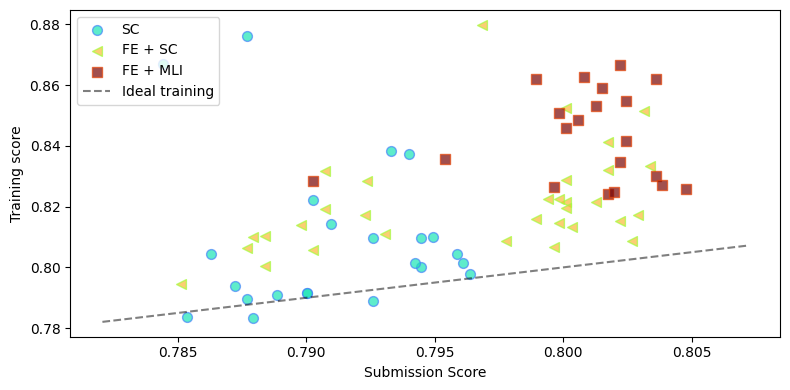

In [17]:
# Load submission results:
df_res_orig_avg = pd.read_csv('kaggle/Training_results/03_submissions_Original_Avg.csv')
df_res_FE_avg = pd.read_csv('kaggle/Training_results/03_submissions_FE_Avg.csv')
df_res_FE_MLI = pd.read_csv('kaggle/Training_results/03_submissions_FE_MLI_G.csv')
# Prepare results and compare them:
results_general = {
    'SC': df_res_orig_avg,
    'FE + SC': df_res_FE_avg,
    'FE + MLI': df_res_FE_MLI,
}
compare_submission_scores(results_general,figsize=(8,4),x_min_filter=0.78)

📊 **Performance plot**

The plot displays all **submission scores** (horizontal axis) and **training scores** (vertical axis) for many ML models, grouped by the **preprocessing strategies**. Here are some guides to read the plot:
- The dashed diagonal line represents the ideal case where training and submission scores are equal (i.e., no overfitting).
- In reality, most models overfit as they are above the ideal curve.
- The **best models** are those **furthest to the right** (high submission score), regardless of their training performance.
- Using **feature engineering (FE)** improves performance compared to just employing the **original information**.
- The **Machine Learning Imputation (MLI)** method outperforms the **standard corrections (SC)**.

In summary, the **MLI strategy** has proven to be an effective approach for handling missing data, **improving my previous benchmark from 0.80336 to 0.80476**. Furthermore, the MLI technique coded in this notebook can be **easily exported** to other workflows as a **general preprocessing strategy**. 

📌 **What's next**

So far, I've demonstrated two preprocessing strategies, which can be applied straightforward to the datasets. However, there's still room for improvement! The next step is to **apply manual corrections first**, using reliable criteria that allow fixing some values with **100% confidence**. After this manual refinement, I will follow up with **Machine Learning Imputation**, which should lead to better submission results.

<a id="Manual-data-correction"></a>
# <span style="color:teal;font-weight:bold;">Manual data correction</span>

Let's come back to the engineered datasets and make a copy that will keep track of the **manual corrections**. Before proceeding, I perform a sanity check to confirm that the missing values are still present:

In [18]:
# Make new datasets that will include manual corrections:
train_df_FE_MC = train_df_FE.copy()
test_df_FE_MC = test_df_FE.copy()
# Compute missing values:
compute_missing_values(train_df_FE_MC,test_df_FE_MC)


Missing values in train/test datasets:

HomePlanet:           201 (2.3%) / 87 (2.0%)
CryoSleep:            217 (2.5%) / 93 (2.2%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  203 (2.3%) / 93 (2.2%)
ExpRS:                181 (2.1%) / 82 (1.9%)
ExpFC:               183 (2.1%) / 106 (2.5%)
ExpSM:                208 (2.4%) / 98 (2.3%)
ExpSpa:              183 (2.1%) / 101 (2.4%)
ExpVR:                188 (2.2%) / 80 (1.9%)
IDgroup:                 0 (0.0%) / 0 (0.0%)
GroupMembers:            0 (0.0%) / 0 (0.0%)
Cabin_Deck:          199 (2.3%) / 100 (2.3%)
Cabin_num:           199 (2.3%) / 100 (2.3%)
Cabin_isPort:        199 (2.3%) / 100 (2.3%)
Name_Last:            200 (2.3%) / 94 (2.2%)
Ocurrence_LastName:   200 (2.3%) / 94 (2.2%)

Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1551/723
Number of rows with 2 missing values: 289/152
Number of rows with 3 missing values: 202/101
Number

In the following, I analyze each individual feature and complete those missing values that can be deducted with **100% confidence**.

<a id="Expense-related-features"></a>
## <span style="color:teal;font-weight:bold;">Expense-related features</span>

The expense-related features *ExpRS*, *ExpFC*, *ExpSM*, *ExpSpa* and *ExpVR* can be combined in a **total expenditure** feature called *ExpTotal*, which will be helpful to make correlations with other features. In addition, I define a new boolean feature named *Exp_zero*, which is True for passengers who **didn't spend anything** during the trip, else False.

In [19]:
import warnings # <sns.kdeplot> gives a warning I couldn't fix, I avoid displaying it...
warnings.simplefilter(action='ignore', category=FutureWarning)

# Expense features:
exp_features = ['ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR']
# Build ExpTotal and Exp_zero for each dataset:
for dataset in [train_df_FE_MC, test_df_FE_MC]:
    # Identify all rows in which the expenses information is complete:
    idx = ((~dataset['ExpRS'].isna()) & 
           (~dataset['ExpFC'].isna()) & 
           (~dataset['ExpSM'].isna()) & 
           (~dataset['ExpSpa'].isna()) & 
           (~dataset['ExpVR'].isna())) # Relevant indexes
    # Initiate ExpTotal as NaN, then complete valid values:
    pd.options.mode.chained_assignment = None  # default='warn'
    dataset['ExpTotal'] = np.nan
    dataset['ExpTotal'][idx] = dataset[exp_features].sum(axis="columns")[idx]
    # Create 'Exp_zero' feature, that checks whether a passenger spent nothing (True) or something (False):
    dataset['Exp_zero'] = np.nan # Initiate with NaN values
    dataset.loc[dataset['ExpTotal']==0,'Exp_zero'] = True # Compute True values
    dataset.loc[dataset['ExpTotal']>0,'Exp_zero'] = False # Compute False values

After exploring the correlation between *ExpTotal* and other features, I found a clear correlation with *Age*: **passengers aged 12 or younger always report zero expenses**! The following plot demonstrates this pattern:

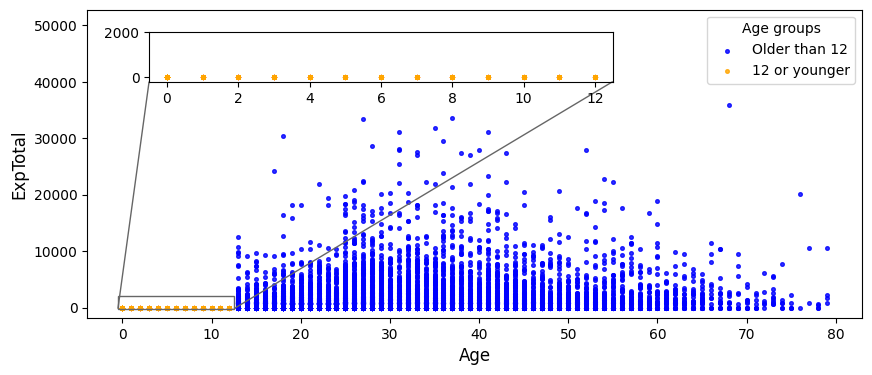

In [20]:
# Merge training and testing datasets:
all_df = pd.concat([train_df_FE_MC, test_df_FE_MC])
# Set age condition:
age_limit = 12 # Set age limit for zoomed-in plot
cond_age = all_df["Age"] <= age_limit

# Plot expenses vs age:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(all_df["Age"][~cond_age],all_df["ExpTotal"][~cond_age],s=7,alpha=0.8,color='blue',label='Older than 12')
ax.scatter(all_df["Age"][cond_age],all_df["ExpTotal"][cond_age],s=7,alpha=0.8,color='orange',label='12 or younger')
ax.set_xlabel('Age',fontsize=12), ax.set_ylabel('ExpTotal',fontsize=12)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+15000)
ax.legend(title='Age groups')
# Zoomed-in image:
axins = zoomed_inset_axes(ax, 4, loc=6, bbox_to_anchor=[180,280,50,50])
axins.scatter(all_df["Age"][cond_age],all_df["ExpTotal"][cond_age],s=7,alpha=0.8,color='orange')
axins.set_xlim(-0.5, age_limit+0.5), axins.set_ylim(-200, 2000)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.4") # Lines for inset image
plt.show()

Consequently, for **passengers featuring *Age*$\leq$12**, I fill all missing values from **expense-related** features as zero.

In [21]:
age_limit = 12 # Set age limit for zoomed-in plot
for dataset in [train_df_FE_MC, test_df_FE_MC]:
    idx = dataset["Age"][dataset["Age"] <= age_limit].index # Relevant indexes
    for feat in exp_features:
        dataset[feat].loc[idx] = 0 # Assign zero expenses for all categories
        dataset['ExpTotal'].loc[idx] = 0 # Assign zero total expenses
        dataset['Exp_zero'].loc[idx] = True # Assign Exp_zero

After this process, **131 missing values were corrected**.

*Note: You can always call the "compute_missing_values" function to monitor how many missing values remain at any stage of the manual corrections process.*

Now, let's turn our attention to the **CryoSleeping passengers**, who most probably did not spend anything during the trip:

In [22]:
# Define plotting functions:
import matplotlib.pyplot as plt
import seaborn as sns

def make_two_feature_chart(df,feat1,feat2,figsize=(10,4)):
    """
    Make a double entry chart, relating two features in the dataset.
    --- Inputs ---
    {df} [Dataframe]: Dataset that will be analyzed.
    {feat1} [String]: Name of one the features to be compared.
    {feat2} [String]: Name of the other feature to be compared.
    {figsize} [Tuple]: Define the size for the figure, in the format (width,length).
    """
    # Group one feature according to the other:
    CDHP_gb = all_df.groupby([feat1,feat2])[feat2].size().unstack().fillna(0)
    # Plot distribution:
    plt.figure(figsize=figsize)
    sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
    plt.show()

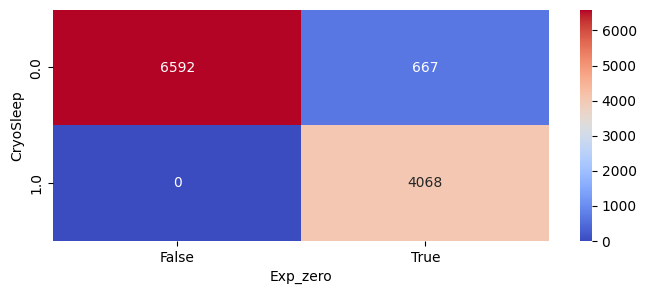

In [23]:
make_two_feature_chart(pd.concat([train_df_FE_MC, test_df_FE_MC]),'Exp_zero','CryoSleep',figsize=(8,3))

As expected, all passengers who were cryo-sleeping (**CryoSleep**=1) spent nothing (**Exp_zero**=True) during the trip. Based on this, I assign **zero expenses** to all missing expense-related values from **cryo-sleeping passengers**: 

In [24]:
for dataset in [train_df_FE_MC, test_df_FE_MC]:
    idx = dataset["CryoSleep"][dataset["CryoSleep"] == True].index # Relevant indexes
    for feat in exp_features:
        dataset[feat].loc[idx] = 0 # Assign zero expenses
        dataset['ExpTotal'].loc[idx] = 0 # Assign zero total expenses
        dataset['Exp_zero'].loc[idx] = True # Assign Exp_zero

This time, **467 missing values were corrected**!

At this point, I wrap up the manual corrections based on the **expense-related features**, as there **no other rules** that can be applied with complete certainty. 

Take the *VIP* feature, for example... it sounds like a good candidate for spending patterns, expecting that wealthy passengers have some expenses. However, although most VIP people spent something, there are some exceptions, then I cannot make any assumptions:

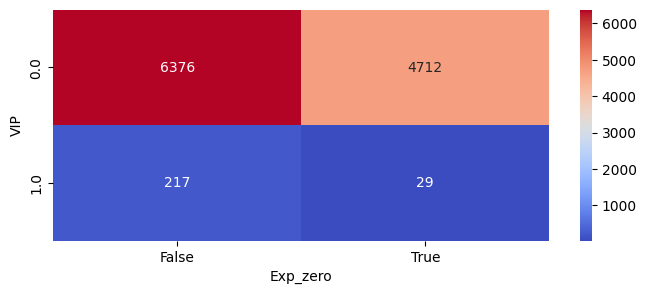

In [25]:
make_two_feature_chart(pd.concat([train_df_FE_MC, test_df_FE_MC]),'Exp_zero','VIP',figsize=(8,3))

<a id="Cryosleep-feature"></a>
## <span style="color:teal;font-weight:bold;">Cryosleep Feature</span>

Before, I demonstrated that passengers who went to cryosleeping spent nothing during the trip. I used this logic to correct the missing expense-related values by assigning zero expenses to all sleeping passengers. 

Now I reverse the reasoning: for any missing *CryoSleep* value, **if the passenger spent something (*Exp_zero*=False), then they were not cryosleeping**. For those cases, I set *CryoSleep*=False.

In [26]:
for dataset in [train_df_FE_MC, test_df_FE_MC]:
    # Correct missing values:
    idx = (dataset['CryoSleep'].isna()) & (dataset['Exp_zero']==False) # Relevant indexes
    dataset['CryoSleep'].loc[idx] = 0

Let me summarize the progress made so far for the *CryoSleep* feature: 
* Initial missing values in train/test datasets: <span style="color:red">217 (2.5%) / 93 (2.2%)</span>.
* Current missing values in train/test datasets: <span style="color:red">111 (1.3%) / 42 (1.0%)</span>.

<a id="HomePlanet-feature"></a>
## <span style="color:teal;font-weight:bold;">HomePlanet feature</span>

Passengers are organized in **groups**, identified by the *IDgroup* feature. These groups share a **common Home planet**, as the next lines of code demonstrate:

In [27]:
def check_group_correlation(df,group_feat,target_feat):
    """
    Check if a target feature is univocally correlated with each unique value of
    the grouping feature. 
    --- Inputs ---
    {df} [Dataframe]: Dataset that will be analyzed.
    {group_feat} [String]: Name of the grouping features, from which the unique values
    will be considered.
    {target_feat} [String]: Name of the target feature to evaluate correlation.
    """
    n = 0 # Auxiliar counter
    for unique_val in set(df[group_feat]):
        # Make a set with all target values for the current grouping unique value (exclude NaN):
        target_values = set([x for x in df[df[group_feat]==unique_val][target_feat] if x==x])
        # If there is more than a single target value in the set, print on screen:
        if len(target_values)>1:
            n += 1
    # Inform conclusion:
    if n == 0:
        print(colored(
            f'{target_feat} is univocally correlated with each unique value of {group_feat}.','green'))
    else:
        print(colored(
            f'{target_feat} is NOT univocally correlated with each unique value of {group_feat}.','red'))
        print(f'There are {n} unique values in {group_feat} for which the univocally correlation is not valid.')

In [28]:
check_group_correlation(pd.concat([train_df_FE_MC, test_df_FE_MC]),'IDgroup','HomePlanet')

HomePlanet is univocally correlated with each unique value of IDgroup.


Consequently, any missing values in *HomePlanet* can be filled with the **known destination of another passenger** with the same *IDgroup*.

In [29]:
def correct_values_for_univocal_group_corr(dfs,group_feat,target_feat):
    """
    Correct missing values based for the target feature based on a univocal
    correlation with unique values of a grouping feature.
    --- Inputs ---
    {dfs} [List]: Each element is a pandas dataframe that will be considered for the
    univocal correlation and then corrected.
    {group_feat} [String]: Name of the grouping features, from which the unique values
    will be considered.
    {target_feat} [String]: Name of the target feature to evaluate correlation.
    """
    all_df = pd.concat(dfs) # Combine datasets
    # Apply corrections for each individual dataset: 
    for df in dfs:
        idx = df.loc[pd.isna(df[target_feat]), :].index # Relevant indexes (NaN values)
        # For each missing value, identify a known value for the grouping feature and correct the target feature:
        for i in idx:
            known_group_val = list(set(
                [x for x in all_df[all_df[group_feat]==df[group_feat][i]][target_feat] if x==x]))
            # Only proceed if there is a known grouping value (rather than only NaN):
            if len(known_group_val)>0:
                df[target_feat].loc[i] = known_group_val[0]

In [30]:
correct_values_for_univocal_group_corr(
    [train_df_FE_MC, test_df_FE_MC],"IDgroup","HomePlanet")

As there are still missing values in the *HomePlanet* feature, I explore its correlation with the *Cabin_Deck* feature, since I previously demonstrated that they are highly correlated (see <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>).

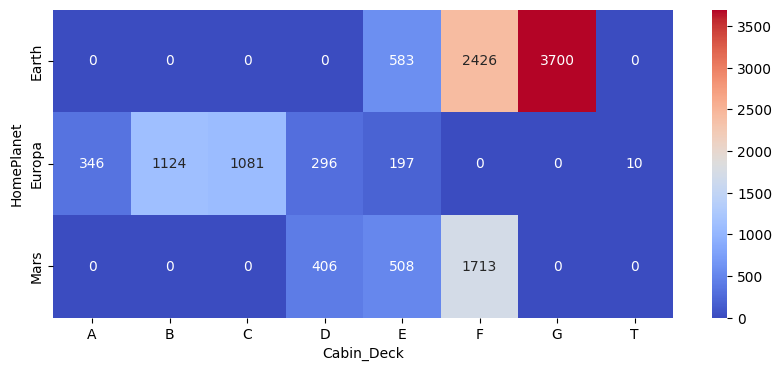

In [31]:
make_two_feature_chart(pd.concat([train_df_FE_MC, test_df_FE_MC]),'Cabin_Deck','HomePlanet',figsize=(10,4))

From this **distribution plot**, I can conclude the following:
- Passengers in *Cabin_Deck* **A,B,C,T** are associated with the *HomePlanet* **Europa**.
- Passengers in *Cabin_Deck* **G** are associated with the *HomePlanet* **Earth**.
- Passengers in *Cabin_Deck* **D,E,F** cannot be clearly assigned to **any** specific *HomePlanet*.

In [32]:
# Assign HomePlanet values based on Cabin:
for dataset in [train_df_FE_MC, test_df_FE_MC]:
    # Cabins A,B,C,T, associated to Europa:
    cond_ABCT = ((dataset["Cabin_Deck"]=="A") |
                 (dataset["Cabin_Deck"]=="B") |
                 (dataset["Cabin_Deck"]=="C") |
                 (dataset["Cabin_Deck"]=="T")) # Define condition
    dataset["HomePlanet"].loc[cond_ABCT] = "Europa" # Apply changes
    # Cabins G, associated to Earth:
    cond_G = dataset["Cabin_Deck"]=="G" # Define condition
    dataset["HomePlanet"].loc[cond_G] = "Earth" # Apply changes

Let's summarize the progress so far for the **HomePlanet** feature: 
* Initial missing values in train/test datasets: <span style="color:red">201 (2.3%) / 87 (2.0%)</span>.
* Current missing values in train/test datasets: <span style="color:red">63 (0.7%) / 31 (0.7%)</span>.

Let's continue the analysis by considering one more correlated feature: *Name_Last*. Similar to the *IDgroup* analysis, I demonstrate that **all passengers sharing the same surname have the same *HomePlanet***:

In [33]:
check_group_correlation(pd.concat([train_df_FE_MC, test_df_FE_MC]),'Name_Last','HomePlanet')

HomePlanet is univocally correlated with each unique value of Name_Last.


Consequently, any missing values in *HomePlanet* can be filled with the **known home planet of another passenger** with the same *Name_Last*.

In [34]:
correct_values_for_univocal_group_corr(
    [train_df_FE_MC, test_df_FE_MC],"Name_Last","HomePlanet")

Excellent news, now the **HomePlanet** feature has only a few remaining missing values! 
* Current missing values in train/test datasets: <span style="color:red">5 (0.1%) / 5 (0.1%)</span>.

<a id="VIP-feature"></a>
## <span style="color:teal;font-weight:bold;">VIP feature</span>

The behavior of Very Important Passengers (*VIP*=True) varies accross differente features, including expenses! However, I did find a **pattern** regarding their **cabin location** and **surname popularity**.

Let's begin by analyzing the *Cabin_Deck* correlations:

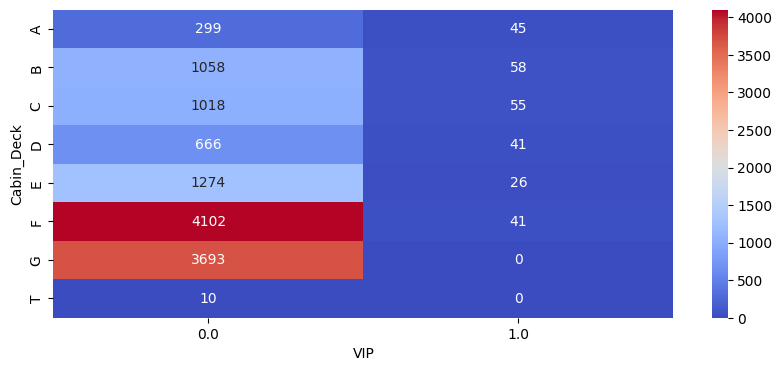

In [35]:
make_two_feature_chart(pd.concat([train_df_FE_MC, test_df_FE_MC]),'VIP','Cabin_Deck',figsize=(10,4))

From this chart, we can conclude that **VIP passengers (*VIP*=1) do not stay in *Cabin_Deck* G or T** (although the latter case is not very reliable, as there are only 10 values). Let's check how many missing values for the *VIP* feature correspond to these cabin decks:

In [36]:
# Combine datasets and prepare condition:
all_df = pd.concat([train_df_FE_MC, test_df_FE_MC])
cond_cabin = ((all_df['VIP'].isna()) &
    ((all_df['Cabin_Deck']=='G') | (all_df['Cabin_Deck']=='T')))
# Count the number of ocurrences for each "Cabin_Deck" for NaN VIP values:
all_df[['VIP','Cabin_Deck']].loc[cond_cabin]['Cabin_Deck'].value_counts()

Cabin_Deck
G    88
T     1
Name: count, dtype: int64

Given that the 'T' deck has very few instances, I do not correct the *VIP* missing for that single passenger in the 'T' cabin.

On the other hand, **I do assign *VIP*=0** (then non-VIP condition) to all those **passengers in deck 'G'**:

In [37]:
for dataset in [train_df_FE_MC, test_df_FE_MC]:
    # Correct missing values:
    idx = (dataset['VIP'].isna()) & (dataset['Cabin_Deck']=='G') # Relevant indexes
    dataset['VIP'].loc[idx] = 0

Lastly, I observe a suggestive correlation between the *VIP* and *Ocurrence_LastName* features, which implies that **VIP passengers are less likely to have very common last names**...

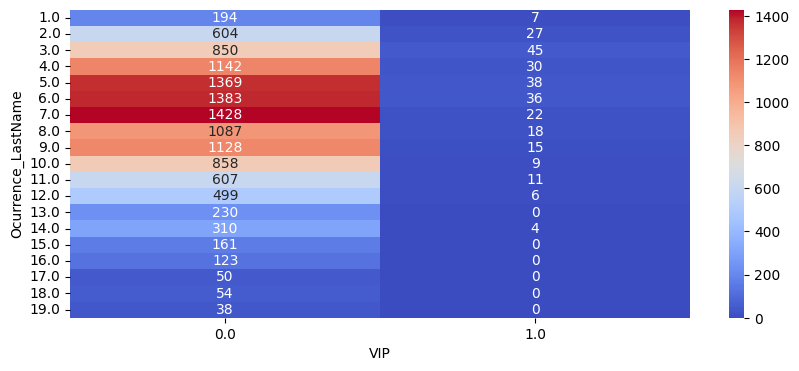

In [38]:
make_two_feature_chart(pd.concat([train_df_FE_MC, test_df_FE_MC]),'VIP','Ocurrence_LastName',figsize=(10,4))

It seems that *Ocurrence_LastName* values greater than 14 implies *VIP*=0. However, **this rule may be misleading**, as the number of *VIP*=1 values is very scarce, making **statistics less reliable**. For example, for *Ocurrence_LastName*=14 and 12, the *VIP*=1 rates are around 0.013 and 0.012, which are very low but not zero. Therefore, finding a *VIP*=1 value for very high *Ocurrence_LastName* value is **very rare, but still possible**.

For this manual correction process, where I'm applyting **rules with 100% confidence**, I have decided **not to use the *Ocurrence_LastName* feature to correct the missing *VIP* values**. And anyway, the number of missing *VIP* values that could be corrected is very small, making this step less impactful:

In [39]:
# Combine datasets and prepare condition:
all_df = pd.concat([train_df_FE_MC, test_df_FE_MC])
cond_cabin = ((all_df['VIP'].isna()) &
    ((all_df['Ocurrence_LastName']>14)))
# Count the number of ocurrences for each "Ocurrence_LastName" for NaN VIP values:
all_df[['VIP','Ocurrence_LastName']].loc[cond_cabin]['Ocurrence_LastName'].value_counts()

Ocurrence_LastName
16.0    4
15.0    2
Name: count, dtype: int64

<a id="Cabin-isPort-feature"></a>
## <span style="color:teal;font-weight:bold;">Cabin_isPort feature</span>

Similar to the *HomePlanet* and *IDgroup* correlation, I observed **passengers who share the same *IDgroup* are located in the same *Cabin_isPort***:

In [40]:
check_group_correlation(pd.concat([train_df_FE_MC, test_df_FE_MC]),'IDgroup','Cabin_isPort')

Cabin_isPort is univocally correlated with each unique value of IDgroup.


Then, I will fill any *Cabin_isPort* missing values with a **known port value** from the same *IDgroup*:

In [41]:
correct_values_for_univocal_group_corr(
    [train_df_FE_MC, test_df_FE_MC],"IDgroup","Cabin_isPort")

In this way, **137 missing *Cabin_isPort* values** were corrected.

<a id="Checkpoint-MC-completed"></a>
## <span style="color:teal;font-weight:bold;">Checkpoint: MC completed</span>

Manual corrections are finished! Using **completely certain correlations**, I have corrected missing values accross many features. As a result, the **fraction of missing data dropping from about 2% to just 1%** in every corrected feature, as shown below:

In [42]:
compute_missing_values(train_df_FE_MC,test_df_FE_MC)


Missing values in train/test datasets:

HomePlanet:              5 (0.1%) / 5 (0.1%)
CryoSleep:            111 (1.3%) / 42 (1.0%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  137 (1.6%) / 71 (1.7%)
ExpRS:                107 (1.2%) / 55 (1.3%)
ExpFC:                106 (1.2%) / 65 (1.5%)
ExpSM:                103 (1.2%) / 60 (1.4%)
ExpSpa:               114 (1.3%) / 52 (1.2%)
ExpVR:                107 (1.2%) / 43 (1.0%)
IDgroup:                 0 (0.0%) / 0 (0.0%)
GroupMembers:            0 (0.0%) / 0 (0.0%)
Cabin_Deck:          199 (2.3%) / 100 (2.3%)
Cabin_num:           199 (2.3%) / 100 (2.3%)
Cabin_isPort:          99 (1.1%) / 63 (1.5%)
Name_Last:            200 (2.3%) / 94 (2.2%)
Ocurrence_LastName:   200 (2.3%) / 94 (2.2%)
ExpTotal:            518 (6.0%) / 267 (6.2%)
Exp_zero:            518 (6.0%) / 267 (6.2%)

Number of rows with 0 missing values: 7259/3572
Number of rows with 1 missing values: 523/243
Number of

*Note*: It's important to highlight that the *ExpTotal* and *Exp_zero* features show a relatively large fraction of missing values, about 6%. This is because these features are built using the expense-related features *ExpRS*, *ExpFC*, *ExpSM*, *ExpSpa* and *ExpVR*, and **any one of these features reporting a missing value translates into a missing value for both *ExpTotal* and *Exp_zero***. The missing rates for the *ExpTotal* and *Exp_zero* features roughly corresponds to the sum of the individual missing fractions in each expense-related feature.

<a id="FE-MC-SC-submission-performance"></a>
## <span style="color:teal;font-weight:bold;">FE+MC+SC submission performance</span>

Having corrected approximately half of the missing values with complete certainty, I now expect to surpass my previous benchmark. I first employ **standard corrections (SC)** to the **feature-engineered (FE)** and **manually-corrected (MC)** datasets, Machine Learning Imputation (MLI) will come later. In the following lines, I import my submission results and visualize them, comparing the new scores against the **earlier 0.80476 benchmark**.

In [43]:
def standard_corrections(df):
    """
    Correct all missing values in a dataset using the mean value for numerical features
    and the mode value for non-numerical features.
    --- Inputs ---
    {df} [Dataframe]: Dataframe to be corrected.
    --- Outputs ---
    {df_corrected} [Dataframe]: Corrected Dataframe.
    """
    # Make a copy of the original dataset:
    df_corrected = df.copy()
    # Correct each feature:
    for feat in df:
        df_corrected = simple_correction_feat(df_corrected,feat)
        
    return df_corrected

In [44]:
# Standard corrections (SC) to FE+MC datasets:
train_df_FE_MC_SC = standard_corrections(train_df_FE_MC)
test_df_FE_MC_SC = standard_corrections(test_df_FE_MC)

# Train a ML model and generate a submission file:
predictor_feats = ['HomePlanet','CryoSleep','Destination','Age','VIP',
                   'ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR','ExpTotal',
                   'Exp_zero','Cabin_Deck','Cabin_num', 'Cabin_isPort']
ML_model = XGBClassifier(n_estimators=100, max_depth=3)
train_score, preds = train_submit_ML(ML_model,
                                     train_df_FE_MC_SC[predictor_feats+['Transported']],
                                     test_df_FE_MC_SC[predictor_feats],
                                     test_ID)

Training score: 0.8407
Submission file ready.


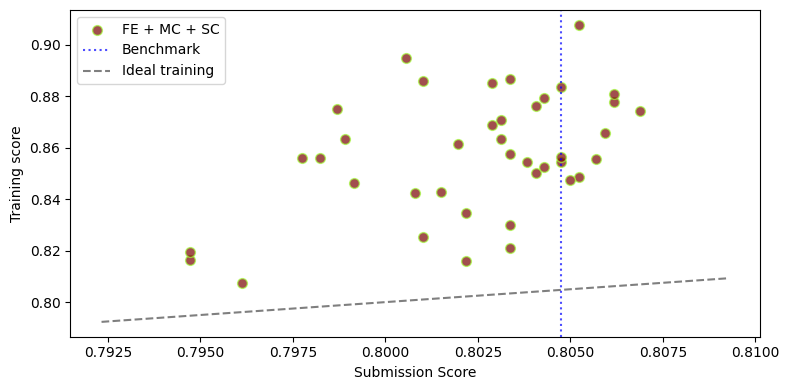

In [45]:
# Import submission results:
df_res_FE_MC_SC = pd.read_csv('kaggle/Training_results/03_submissions_FE_MC_Avg.csv')
# Prepare results and compare them:
results_FE_MC_SC = {
    'FE + MC + SC': df_res_FE_MC_SC,
}
compare_submission_scores(results_FE_MC_SC,figsize=(8,4),benchmark=0.80476)

Excellent news: the **new best score is 0.80687**! Can I go even further? In the previous experience, without manual corrections, MLI worked slightly better than SC, so I expect that **applying MLI on top of the FE+MC datasets** can push my score a little ahead.

<a id="MC-plus-MLI"></a>
# <span style="color:teal;font-weight:bold;">Manual corrections + ML imputation</span>

In this section, I apply **Machine Learning Imputation to the feature-engineered and manually-corrected datasets**. The full process involves first optimizing the ML hyperparameters, and then performing the imputation itself.

To get started, I go back to the FE+MC datasets, and make sure that the missing values are still there:

In [46]:
# Check missing values:
compute_missing_values(train_df_FE_MC,test_df_FE_MC)


Missing values in train/test datasets:

HomePlanet:              5 (0.1%) / 5 (0.1%)
CryoSleep:            111 (1.3%) / 42 (1.0%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  137 (1.6%) / 71 (1.7%)
ExpRS:                107 (1.2%) / 55 (1.3%)
ExpFC:                106 (1.2%) / 65 (1.5%)
ExpSM:                103 (1.2%) / 60 (1.4%)
ExpSpa:               114 (1.3%) / 52 (1.2%)
ExpVR:                107 (1.2%) / 43 (1.0%)
IDgroup:                 0 (0.0%) / 0 (0.0%)
GroupMembers:            0 (0.0%) / 0 (0.0%)
Cabin_Deck:          199 (2.3%) / 100 (2.3%)
Cabin_num:           199 (2.3%) / 100 (2.3%)
Cabin_isPort:          99 (1.1%) / 63 (1.5%)
Name_Last:            200 (2.3%) / 94 (2.2%)
Ocurrence_LastName:   200 (2.3%) / 94 (2.2%)
ExpTotal:            518 (6.0%) / 267 (6.2%)
Exp_zero:            518 (6.0%) / 267 (6.2%)

Number of rows with 0 missing values: 7259/3572
Number of rows with 1 missing values: 523/243
Number of

<a id="Optimization-and-imputation"></a>
## <span style="color:teal;font-weight:bold;">Optimization and imputation</span>

For these FE+MC datasets, I performed several versions of the **hyperparameters optimization, ML imputation and competition submissions**, which will be summarized in the performance section.

Below, I show a **reasoning example** for the configuration that delivered the best results: 

In [47]:
# Some options for hyperparameters exploration:   
hyps_dict = {
    'HomePlanet': {'n_est_opts': [300,400,500], 'max_d_opts': [3,4,5]},
    'CryoSleep': {'n_est_opts': [100,125,150], 'max_d_opts': [3,4,5]},
    'Destination': {'n_est_opts': [75,100,125], 'max_d_opts': [2,3,4]},
    'Age': {'n_est_opts': [10,30,50], 'max_d_opts': [3,4,5]},
    'VIP': {'n_est_opts': [75,100,125], 'max_d_opts': [5,6,7]},
    'ExpRS': {'n_est_opts': [1250,1500,1750], 'max_d_opts': [1,2,3]},
    'ExpFC': {'n_est_opts': [1250,1500,1750], 'max_d_opts': [1,2,3]},
    'ExpSM': {'n_est_opts': [800,1000,1200], 'max_d_opts': [2,3,4]},
    'ExpSpa': {'n_est_opts': [1250,1500,1750], 'max_d_opts': [1,2,3]},
    'ExpVR': {'n_est_opts': [800,1000,1200], 'max_d_opts': [2,3,4]},
    'Cabin_Deck': {'n_est_opts': [300,500,700], 'max_d_opts': [4,5,6]},
    'Cabin_num': {'n_est_opts': [75,100,125], 'max_d_opts': [2,3,4]},
    'Cabin_isPort': {'n_est_opts': [300,500,700], 'max_d_opts': [4,5,6]},
}

# Choose optimize_hyps=True if you want to run the ML optimization process:
optimize_hyps = False
if optimize_hyps:
    # Impute missing values using ML:
    for feat in hyps_dict:
        # Correct missing values on single feature for both training and testing datasets:
        n_est_options = hyps_dict[feat]['n_est_opts']
        max_d_options = hyps_dict[feat]['max_d_opts']
        ML_data_imp_optim([train_df_FE_MC,test_df_FE_MC],feat,
                          n_est_options=n_est_options,max_d_options=max_d_options,
                          reg_error='RMSE',cla_error='F1')

After the exploration process, I was able to select the **optimal hyperparameters** and summarize them in the following table:

| Feature | ML model | n_estimators | max_depth | Class. score | Reg. score | Mean value (Reg.) |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **HomePlanet** | GBC | 400 | 4 | **0.9686** | - | - |
| **CryoSleep** | GBR | 125 | 4 | **0.9325** | - | - |
| **Destination** | GBC | 100 | 3 | **0.7006** | - | - |
| **Age** | GBR | 30 | 4 | - | **12.33** | 28.64 |
| **VIP** | GBR | 100 | 6 | **0.1724** | - | - |
| **ExpRS** | GBR | 1500 | 2 | - | **172.51** | 212.26 |
| **ExpFC** | GBR | 1500 | 1 | - | **184.34** | 439.83 |
| **ExpSM** | GBR | 1000 | 3 | - | **188.61** | 169.16 |
| **ExpSpa** | GBR | 1500 | 2 | - | **238.66** | 296.41 |
| **ExpVR** | GBR | 1000 | 3 | - | **215.14** | 288.30 |
| **Cabin_Deck** | GBC | 500 | 5 | **0.8237** | - | - |
| **Cabin_num** | GBR | 100 | 3 | - | **394.22** | 604.68 |
| **Cabin_isPort** | GBR | 500 | 5 | **0.5080** | - | - |

In the previous [Hyperparameters optimization](#Hyperparameters-optimization) section, I obtained a similar table for the feature-engineered datasets, without manual corrections. After incorporating the manual corrections, the **current optimization outperforms the previous one**, showing better scores for some features while mantaining similar performance for others.

The features that keep the same performance compared to the earlier version include: *HomePlanet*, *CryoSleep*, *Destination*, *Age*, *VIP*, *Cabin_num*, *Cabin_isPort*.

⬆️ **Features that show better performance after manual correction**:

- All **expense-related features** (*ExpRS*, *ExpFC*, *ExpSM*, *ExpSpa*, *ExpVR*) **reduced the RMSE score notoriously**, from values above 500 (and above 1,000 in some cases) to around 200.

- ***Cabin_Deck* predictions improved the F1-score** from 0.6823 to 0.8237.

In [48]:
# Optimization gave the following results:
best_hyps_FE_MC = {
    'HomePlanet': {'ML_model':'GBC','n_est': 400, 'max_d': 4},
    'CryoSleep': {'ML_model':'GBR','n_est': 125, 'max_d': 4},
    'Destination': {'ML_model':'GBC','n_est': 100, 'max_d': 3},
    'Age': {'ML_model':'GBR','n_est': 30, 'max_d': 4},
    'VIP': {'ML_model':'GBR','n_est': 100, 'max_d': 6},    
    'ExpRS': {'ML_model':'GBR','n_est': 1500, 'max_d': 2},
    'ExpFC': {'ML_model':'GBR','n_est': 1500, 'max_d': 1},
    'ExpSM': {'ML_model':'GBR','n_est': 1000, 'max_d': 3},
    'ExpSpa': {'ML_model':'GBR','n_est': 1500, 'max_d': 2},
    'ExpVR': {'ML_model':'GBR','n_est': 1000, 'max_d': 3},    
    'Cabin_Deck': {'ML_model':'GBC','n_est': 500, 'max_d': 5},
    'Cabin_num': {'ML_model':'RFR','n_est': 100, 'max_d': 3},
    'Cabin_isPort': {'ML_model':'GBR','n_est': 500, 'max_d': 5},    
}

The next lines allow to impute the FE+MC datasets and **generate the ML imputed datasets: FE+MC+MLI**. 

Since the imputation process can be quite time-consuming task, I instead load a previously saved dataset, which was generated using the **hyperparameters defined above and a parallel imputation process** (constructive=False).

In [49]:
# Prepare parameters for data imputation
run_imputation = False # Choose whether to run the data imputation or just load previous results
best_hyps = best_hyps_FE_MC # ML hyperparameters
dfs_input = [train_df_FE_MC,test_df_FE_MC] # Input datasets
if run_imputation:
    # Run ML imputation:
    train_df_FE_MC_MLI, test_df_FE_MC_MLI = ML_impute_complete_dataset(
        dfs_input,best_hyps,constructive=False,save_path='./')
    # Generate 'ExpTotal' and 'Exp_zero' features:
    for df in [train_df_FE_MC_MLI, test_df_FE_MC_MLI]:
        add_ExpTotal_Exp_zero(df)
else:
    # Load previous results:
    train_df_FE_MC_MLI = pd.read_csv('kaggle/Imputed_data/train_FE_MC_MLI_round_D.csv') # Training dataset
    test_df_FE_MC_MLI = pd.read_csv('kaggle/Imputed_data/test_FE_MC_MLI_round_D.csv') # Testing dataset

Let's make a final check and see if the **missing values were corrected for all target features**:

In [50]:
# Check missing values:
target_feats = [feat for feat in best_hyps_FE_MC] # Target features
compute_missing_values(train_df_FE_MC_MLI[target_feats], test_df_FE_MC_MLI[target_feats])


Missing values in train/test datasets:

HomePlanet:              0 (0.0%) / 0 (0.0%)
CryoSleep:               0 (0.0%) / 0 (0.0%)
Destination:             0 (0.0%) / 0 (0.0%)
Age:                     0 (0.0%) / 0 (0.0%)
VIP:                     0 (0.0%) / 0 (0.0%)
ExpRS:                   0 (0.0%) / 0 (0.0%)
ExpFC:                   0 (0.0%) / 0 (0.0%)
ExpSM:                   0 (0.0%) / 0 (0.0%)
ExpSpa:                  0 (0.0%) / 0 (0.0%)
ExpVR:                   0 (0.0%) / 0 (0.0%)
Cabin_Deck:              0 (0.0%) / 0 (0.0%)
Cabin_num:               0 (0.0%) / 0 (0.0%)
Cabin_isPort:            0 (0.0%) / 0 (0.0%)

Number of rows with 0 missing values: 8693/4277


<a id="FE-MC-MLI-submission-performance"></a>
## <span style="color:teal;font-weight:bold;">FE+MC+MLI submission performance</span>

We've finally reached the last step in this notebook! In the following, I evaluate the submission performance using the **full data edition workflow**, which includes:

- **Feature engineering (FE)**
- **Manual corrections (MC)**
- **Machine learning imputation (MLI)**

The code below allows to train a ML model, predict the *Transported* feature for the test dataset, and export a submission file.

In [51]:
# Train a ML model and generate a submission file:
predictor_feats = ['HomePlanet','CryoSleep','Destination','Age','VIP',
                   'ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR','ExpTotal',
                   'Exp_zero','Cabin_Deck','Cabin_num', 'Cabin_isPort']
ML_model = XGBClassifier(n_estimators=100, max_depth=3)
train_score, preds = train_submit_ML(ML_model,
                                     train_df_FE_MC_MLI[predictor_feats+['Transported']],
                                     test_df_FE_MC_MLI[predictor_feats],
                                     test_ID)

Training score: 0.8444
Submission file ready.


Next, I **import my submission results** obtained from different Machine Learning models and compare with the **last benchmark 0.80687**.

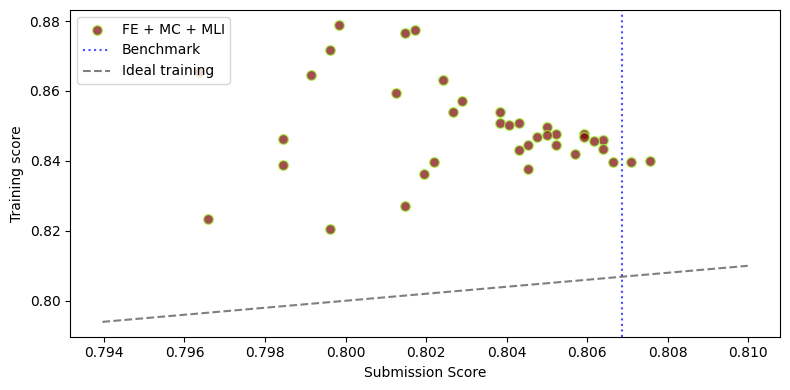

In [52]:
# Import submission results:
df_res_FE_MC_MLI = pd.read_csv('kaggle/Training_results/03_submissions_FE_MC_MLI_D.csv')
# Prepare results and compare them:
results_FE_MC_MLI = {
    'FE + MC + MLI': df_res_FE_MC_MLI,
}
compare_submission_scores(results_FE_MC_MLI,figsize=(8,4),benchmark=0.80687)

🎉 Wonderful!! The **best score is now 0.80757**! When I first submitted this result on 2025-04-16, I broke into the **Top 100 Leaderboard positions**, out of around 2,000 competitors, meaning that my submission was **among the top 5% public results**. Using that Leaderboard data, I can reproduce the summary plot introduced at the beginning of this notebook:

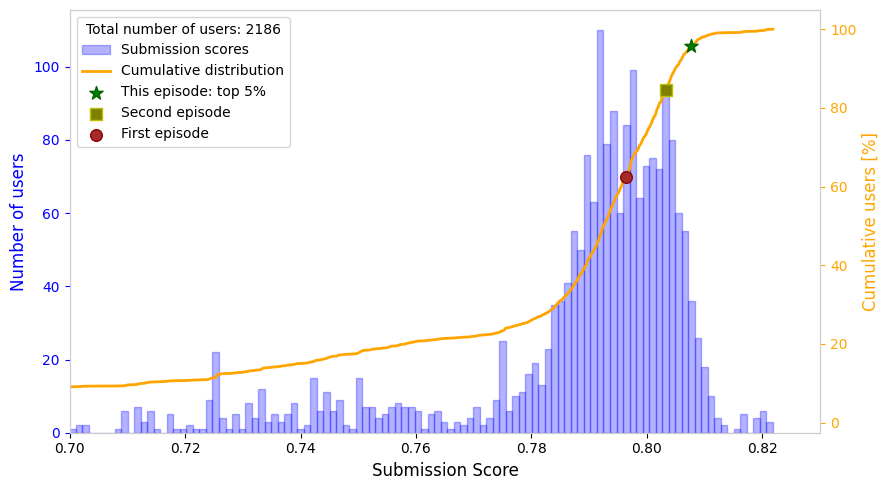

In [53]:
# Load leaderboard scores:
LB_file = "kaggle/Leaderboard/spaceship-titanic-publicleaderboard-2025-04-16.csv"
LB_scores = pd.read_csv(LB_file)['Score'].sort_values() # Scores (fractions from 0 to 1)
# Determine cumulative scores:
cum_scores = np.array([sum(LB_scores<=score) for score in LB_scores])/len(LB_scores)*100 # [%]
# Determine my best score in this notebook and my position among the best scores:
my_best_score = max(df_res_FE_MC_MLI['subm_score'])
top_position = -int(sum(LB_scores<=my_best_score)/len(LB_scores)*100-100)+1 # [%]
# Determine my position according to my previous scores:
score_1 = 0.79635
top_position_1 = -int(sum(LB_scores<=score_1)/len(LB_scores)*100-100)+1 # [%]
score_2 = 0.80336
top_position_2 = -int(sum(LB_scores<=score_2)/len(LB_scores)*100-100)+1 # [%]

# Create figure with two axes (double Y-plot)
fig, ax1 = plt.subplots(figsize=(9,5))
ax2 = ax1.twinx()

# Plot scoring histogram with zoomed-in region:
hist = LB_scores.hist(bins=len(LB_scores)//3,alpha=0.3,grid=False,color='blue',edgecolor='blue',
                      ax=ax1,label='Submission scores')

# Plot cumulative scoring by number of users and my position:
ax2.plot(LB_scores,cum_scores,label='Cumulative distribution',lw=2,color='orange',zorder=1)
ax2.scatter(my_best_score,sum(LB_scores<=my_best_score)/len(LB_scores)*100,
            marker='*',color='g',edgecolor='darkgreen',s=100,zorder=2,alpha=1,
            label=f'This episode: top {top_position}%')
ax2.scatter(score_2,sum(LB_scores<=score_2)/len(LB_scores)*100,
            marker='s',color='olive',edgecolor='y',s=70,zorder=2,alpha=1,
            label='Second episode')
ax2.scatter(score_1,sum(LB_scores<=score_1)/len(LB_scores)*100,
            marker='o',color='brown',edgecolor='darkred',s=70,zorder=2,alpha=1,
            label='First episode')

# Title and axes configuration:
ax1.set_xlabel('Submission Score',fontsize=12)
ax1.set_ylabel('Number of users',fontsize=12,color='blue')
ax2.set_ylabel('Cumulative users [%]',fontsize=12,color='orange')
plt.xlim([0.7,LB_scores.max()*1.01])
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='orange')
for spin in ['bottom','top','right','left']:
    for ax in [ax1,ax2]:
        ax.spines[spin].set_color('#cccccc')

# Legend configuration:
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, title=f'Total number of users: {len(LB_scores)}')

fig.tight_layout()

<a id="Conclusions"></a>
## <span style="color:teal;font-weight:bold;">Conclusions</span>

This notebook was focused on **data correction techniques**, using engineered features and combining **manual corrections** and **Machine Learning imputation** to boost the competition submission scores. And I succeeded in that goal! My best score improved from the initial **0.80336** benchmark to **0.80757**, ranking in the 5% top scores on the Leaderboard.

The gradual progress is summarized in the figure below, highlighting that **Machine Learning imputation** outperformed standard correction for filling missing values. Also, I demonstrate here that the greatest contribution came from the 100% confident **manual corrections**. The **combination of both techniques** ultimately led to achieving the **best score** of 0.80757.

[<img src="https://github.com/Fertmeneses/titanic-spaceship-kaggle/blob/main/assets/03_summary_progression.png?raw=true" width=600>](Summary_progression)

**Thanks a lot for reading my notebook!** It's a great pleasure to share my thoughts and results with the community, and I would love to hear any feedback you may have. Please feel free to leave any comments! 😁

In [54]:
# # Best submission result for each data+ML model:
# all_results = results_general | results_FE_MC_SC | results_FE_MC_MLI
# best_subm_scores = {x:max(all_results[x]['subm_score']) for x in all_results}
# fig = plt.figure(figsize=(8,5))
# plt.bar(range(len(best_subm_scores)),
#         list(best_subm_scores.values()), 
#         tick_label=list(best_subm_scores.keys()))
# plt.xticks(rotation=30)
# plt.ylim([0.793,0.81])
# plt.xlabel('Data corrections')
# plt.ylabel('Submission score')
# fig.tight_layout()
# plt.savefig('assets/03_summary_Methods_results.svg',transparent=True,format="svg")